Building makemore Part 3: Activations & Gradients, BatchNorm
Exercises:

- E01: I did not get around to seeing what happens when you initialize all weights and biases to zero. Try this and train the neural net. 
You might think either that 
1) the network trains just fine or 
2) the network doesn't train at all, but actually it is 
3) the network trains but only partially, and achieves a pretty bad final performance. Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.

- E02: BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training, the batchnorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need to forward it at test time.\
Set up a small 3-layer MLP with batchnorms, train the network, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm. Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.

I decided I'll take the opportunity here and build everyting from scratch. 

In [28]:
import torch
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [29]:
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [30]:
len(words)

32033

In [31]:
# build vocab
chars = list(sorted(set(''.join(words)))) # get all letters / our vocab
stoi = {s:i+1 for i,s in enumerate(chars)} # map each letter to number
stoi['.'] = 0 # make . 0 since it's start and end
itos = {i:s for s,i in stoi.items()} # reverse mapping

In [32]:
block_size = 3
vocab_size = len(itos)

In [33]:
def build_dataset(words):
    ''' Creates input tensor X and output tensor Y from a list of words'''
    X, Y = [], []
    
    for word in words:
        context = [0] * block_size
        
        for char in word + '.':
            ix = stoi[char]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    print(X.shape, Y.shape)

    return X, Y

In [34]:
# create train, dev and test datasets with 80/10/10 split
random.shuffle(words) # randomly shuffle words
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182572, 3]) torch.Size([182572])
torch.Size([22790, 3]) torch.Size([22790])
torch.Size([22784, 3]) torch.Size([22784])


In [35]:
g = torch.Generator().manual_seed(42)

In [54]:
# build the linear layer
# has a number of neurons = fan_out with weights (fan_in) and biases (n = fan_out)
# when called on input (x) performs X @ W + b if bias is True

class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 #make uniform initialization
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x@self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
        
    def parameters(self):
        return [self.weight] + [self.bias] if self.bias is not None else [self.weight]

In [38]:
# buils Tanh 
class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

NB: BatchNorm1D implements:

$$y = \frac{x - \mathbb{E}[x]}{\sqrt{\sigma^2[x] + \epsilon}} * \gamma + \beta$$

In [39]:
# build BatchNorm1d 
# BatchNorm1d(num_features, eps=1e-05, momentum=0.1)
# takes output of X @ W before it goes into tanh then normalizes

class BatchNorm1d:

    def __init__(self, num_features, eps=1e-05, momentum=0.1):
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.Training = True

        # gain and bias
        self.gamma = torch.ones(num_features)
        self.beta = torch.zeros(num_features)

        # running mean and variance
        self.running_mean = torch.zeros(num_features)
        self.running_var = torch.ones(num_features)


    def __call__(self, x):
        if self.Training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
            
        xhat = (x - xmean) / torch.sqrt((xvar + self.eps))
        self.out = self.gamma * xhat + self.beta
        
        if self.Training:
            with torch.no_grad():
                # compute running mean and variance
                running_mean = self.momentum * xmean + (1- self.momentum) * xmean
                running_var = self.momentum * xvar + (1 - self.momentum) * xvar
                
        return self.out


    def parameters(self):
        return [self.gamma, self.beta]
        

Now, to the questions:

### E01: 

I did not get around to seeing what happens when you initialize all weights and biases to zero. Try this and train the neural net. 
You might think either that 
1) the network trains just fine or 
2) the network doesn't train at all, but actually it is 
3) the network trains but only partially, and achieves a pretty bad final performance.

Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.

In [40]:
n_features = 10
n_hidden = 100
batch_size = 32
max_iters = 200000

C = torch.randn((vocab_size, n_features))

# layers = [Linear(block_size*n_features, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#          Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#          Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#          Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#          Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#          Linear(n_hidden, vocab_size, bias=False),]


layers = [Linear(block_size*n_features, n_hidden), Tanh(),
         Linear(n_hidden, n_hidden), Tanh(),
         Linear(n_hidden, n_hidden), Tanh(),
         Linear(n_hidden, n_hidden), Tanh(),
         Linear(n_hidden, n_hidden), Tanh(),
         Linear(n_hidden, vocab_size),]

# make last layer less confident
with torch.no_grad():
    layers[-1].weight *= 0.1

# zero the weights and baises
for layer in layers:
    if isinstance(layer, Linear):
        layer.weight.zero_()

In [41]:
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

46497


In [42]:
lossi = []
ud = [] #monitor how much a weight gets updated relative to its gradient

for i in range(max_iters):

    # mini-batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size, )) # get rand indices for batch
    xb, yb = Xtr[ix], Ytr[ix] # get x, y of batch

    # forward pass
    embenc = C[xb] # get the embedding layer weights
    x = embenc.view(-1, block_size*n_features)  # adjust shape

    for layer in layers:
        x = layer(x)

    loss = F.cross_entropy(x, yb)

    # backward pass

    for layer in layers: # we want to be able to store grads for the intermediate layers (non-leaf nodes) 
        layer.out.retain_grad() # so that we can plot them later
        
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([(lr * p.grad).std() / p.data.std().log10().item() for p in parameters])
    

    if i >= 3000:
        break
    
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_iters:7d}: {loss.item():.4f}')

      0/ 200000: 3.2958


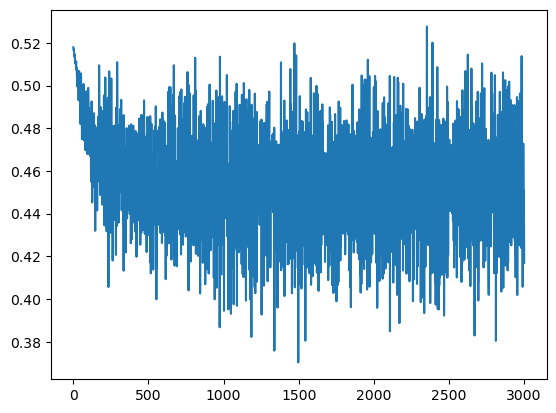

In [43]:
plt.plot(range(len(lossi)), lossi);

`torch.histogram(input, bins=, density=) --> hist, bins`: 

Takes Tensor as input, returns the frequency counts of the values in the Tensor. 


`density` (bool) – If False, the result will contain the count (or total weight) in each bin. If True, the result is the value of the probability density function over the bins, normalized such that the integral over the range of the bins is 1.

`hist`: This is an array containing the frequency or count of values in each bin. It represents the y-values of the histogram. The length of hist is equal to the number of bins you specified when computing the histogram.

`bins`: This is an array that defines the edges of the bins. It's one element longer than the hist array because it includes the endpoints of the bins. Each value in bins indicates the start and end point of a bin. The values in bins are typically used to plot the histogram along the x-axis.

Example:

```
# Create a random tensor
tensor = np.random.randint(0, 100, size=(100,))

# Compute histogram
hist, bins = np.histogram(tensor.float(), bins=10)  # Adjust the number of bins as needed. Only takes floats.
```

In [44]:
for i, l in enumerate(layers):
    print(i, l.__class__.__name__)

0 Linear
1 Tanh
2 Linear
3 Tanh
4 Linear
5 Tanh
6 Linear
7 Tanh
8 Linear
9 Tanh
10 Linear


In [45]:
for l in layers:
    for p in l.parameters():
        print(p.shape)

torch.Size([30, 100])
torch.Size([100])
torch.Size([100, 100])
torch.Size([100])
torch.Size([100, 100])
torch.Size([100])
torch.Size([100, 100])
torch.Size([100])
torch.Size([100, 100])
torch.Size([100])
torch.Size([100, 27])
torch.Size([27])


In [46]:
for p in parameters:
    print(p.shape)

torch.Size([27, 10])
torch.Size([30, 100])
torch.Size([100])
torch.Size([100, 100])
torch.Size([100])
torch.Size([100, 100])
torch.Size([100])
torch.Size([100, 100])
torch.Size([100])
torch.Size([100, 100])
torch.Size([100])
torch.Size([100, 27])
torch.Size([27])


#### Visualizations

layer 1 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 3 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 7 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 9 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


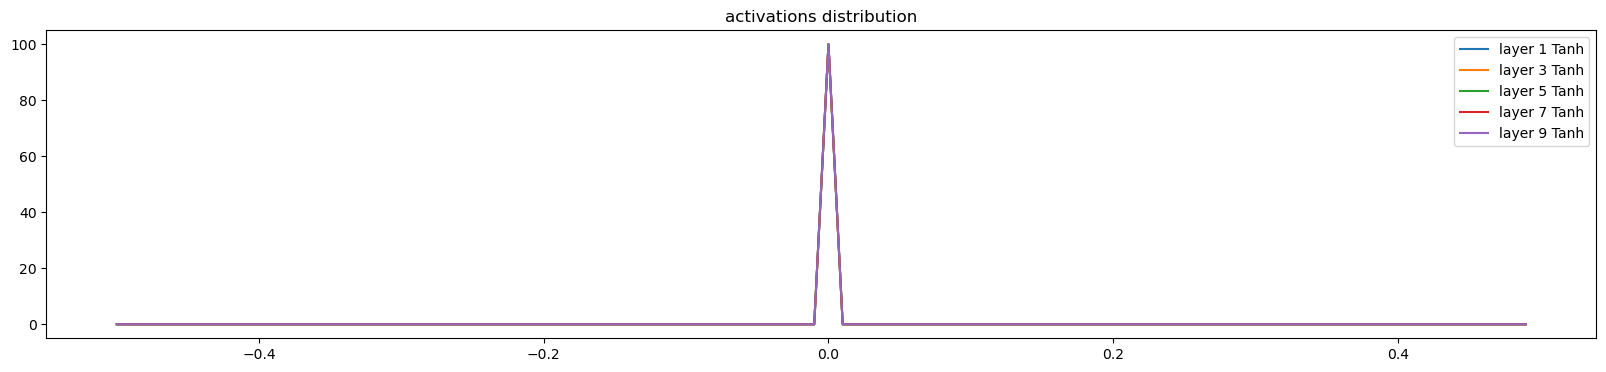

In [47]:
plt.figure(figsize=(20,4))
legends = []

for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True) # get prob density (not absolute counts)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} {layer.__class__.__name__}')
plt.legend(legends);
plt.title('activations distribution');

layer 1 (      Tanh): mean +0.000000, std 0.000000e+00
layer 3 (      Tanh): mean +0.000000, std 0.000000e+00
layer 5 (      Tanh): mean +0.000000, std 0.000000e+00
layer 7 (      Tanh): mean +0.000000, std 0.000000e+00
layer 9 (      Tanh): mean +0.000000, std 0.000000e+00


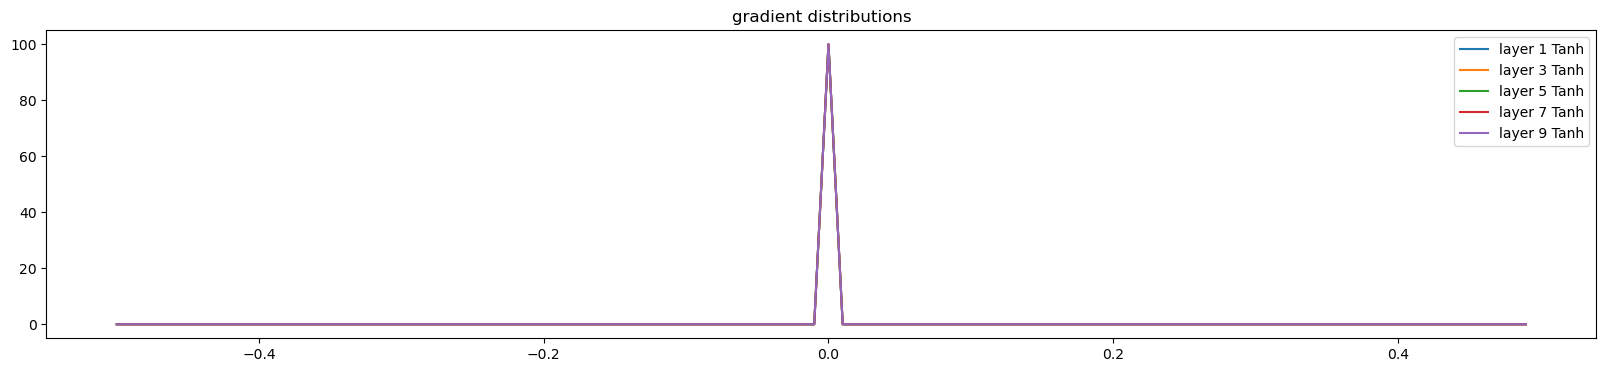

In [48]:
# let's look at the gradients of these layers
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        # get its output
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        # histogram it
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} {layer.__class__.__name__}')

plt.legend(legends);
plt.title('gradient distributions');

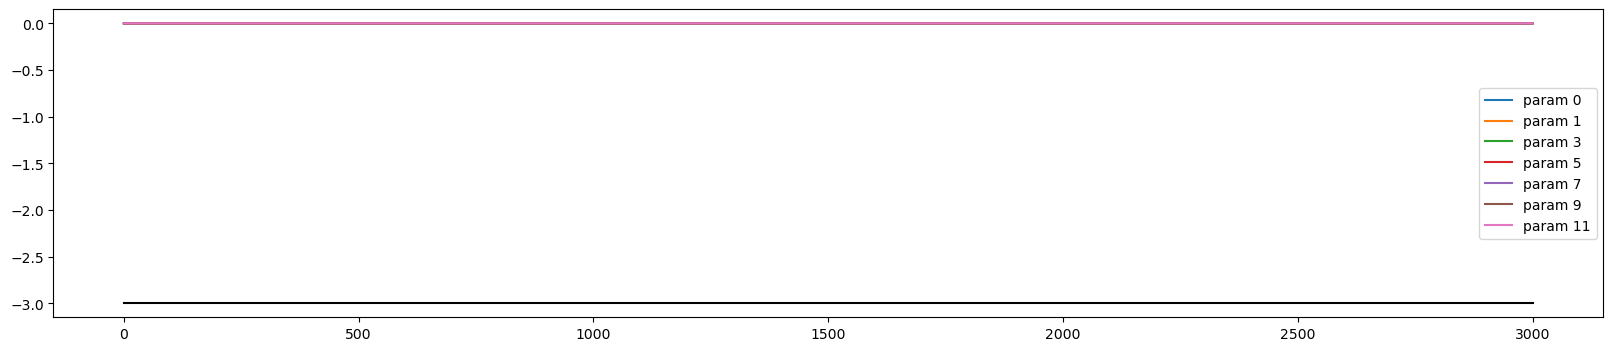

In [49]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim==2: # to get the weights
        plt.plot([ud[j][i] for j,_ in enumerate(ud)])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k');
plt.legend(legends);

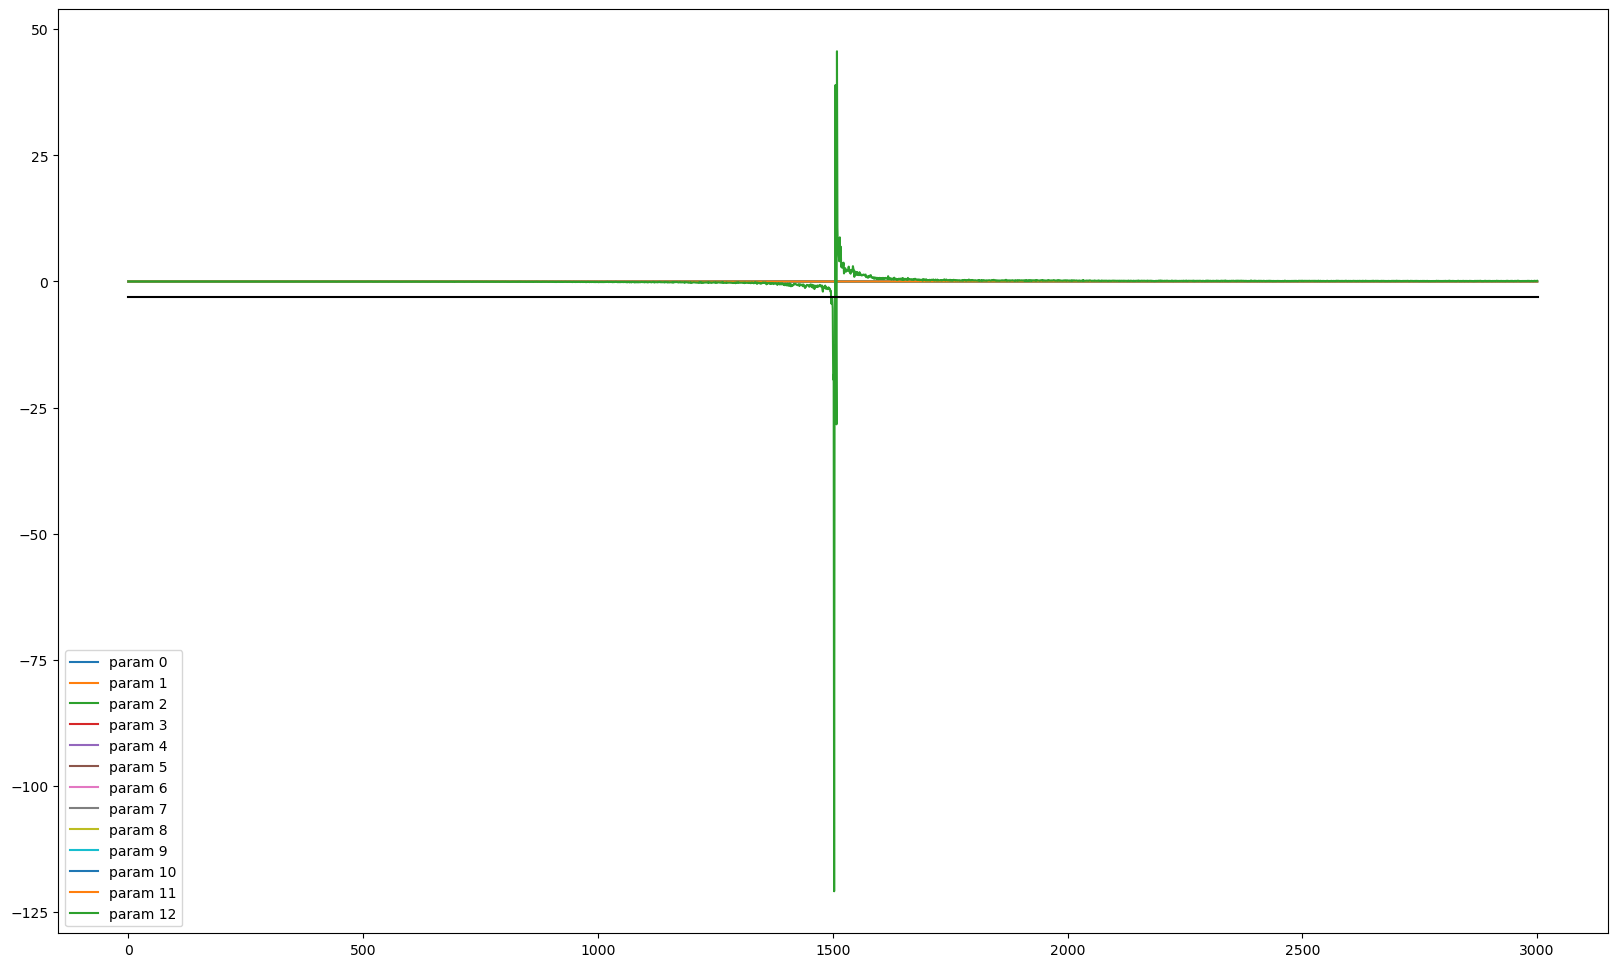

In [50]:
plt.figure(figsize=(20, 12))
legends = []
for i, p in enumerate(parameters):
    plt.plot([ud[j][i] for j,_ in enumerate(ud)])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k');
plt.legend(legends);

weight   (27, 10) | mean +0.000000 | std 0.000000e+00 | grad:data ratio 0.000000e+00
weight  (30, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight  (100, 27) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan


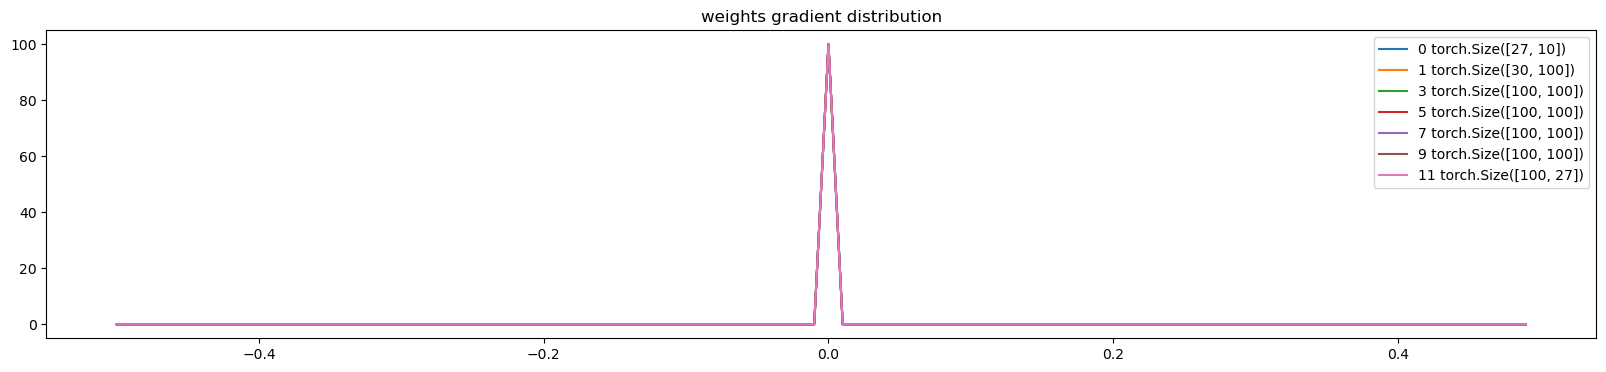

In [51]:
# let's plot grad:data 
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim==2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True) 
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {t.shape}')
        
plt.legend(legends);
plt.title('weights gradient distribution');

So, it looks like no training is going on when we look at activations or weights. Despite that, loss is going down a bit. Let's check other parameters (biases and else).

bias     (100,) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
bias     (100,) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
bias     (100,) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
bias     (100,) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
bias     (100,) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
bias      (27,) | mean +0.000000 | std 4.666655e-02 | grad:data ratio 4.298906e-02


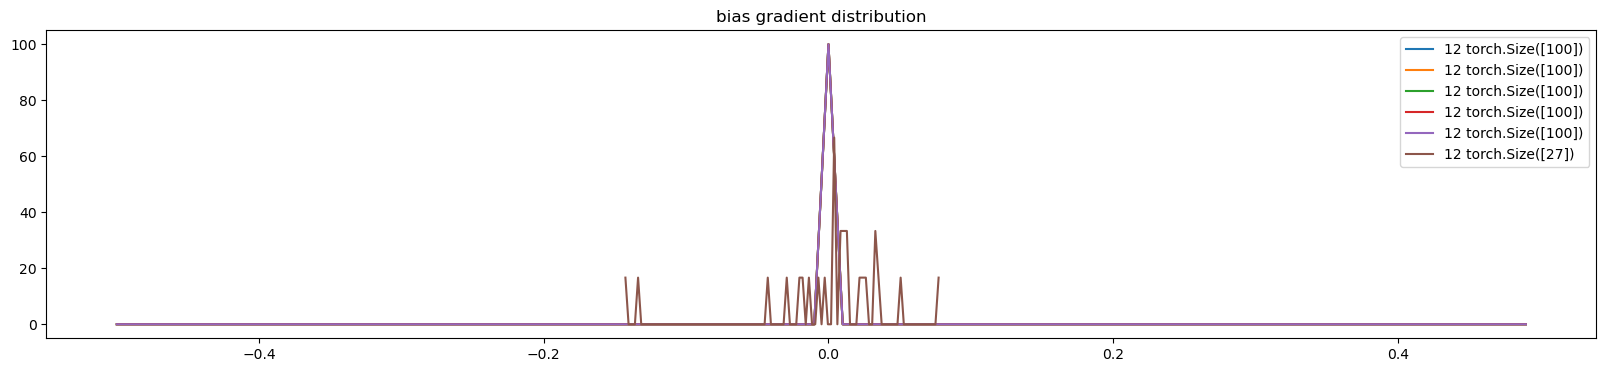

In [52]:
plt.figure(figsize=(20, 4))
legends = []
for p in parameters:
    t = p.grad
    if p.ndim==1:
        print('bias %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {t.shape}')
plt.legend(legends);
plt.title('bias gradient distribution');

Seems like only the biases of the last layer are training.Why? \
If we think about what is happening, we're initializaing all weights and biases to 0. Each linear operation `X @ W + b` will result in 0. But then we get to the last layer - where loss is calculated. Now, the gradient of W, b in `X @ W + b` needs to be calculated w.r.t loss. `W` and `b` should change, but because `W` is being multiplied by `X` coming from previous layer (resulting from a previous `X @ W` = 0), we only see the change in `b`

### E02:

BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training, the batchnorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need to forward it at test time.

Set up a small 3-layer MLP with batchnorms, train the network, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm. Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.

In [337]:
# set up the 3 layer MLP and train it

C = torch.randn((vocab_size, n_features), generator=g)
layers = [Linear(block_size * n_features, n_hidden, bias=True), BatchNorm1d(n_hidden), Tanh(),
         Linear(n_hidden, vocab_size), ]

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum([p.nelement() for p in parameters]))

for p in parameters:
    p.requires_grad=True

# make last layer less confident
with torch.no_grad():
    layers[-1].weight *= 0.1

6297


In [338]:
lossi = []

for i in range(max_iters):
    # construct batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    
    for layer in layers:
        x = layer(x)

    loss = F.cross_entropy(x, Yb)
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    lossi.append(loss.log10().item())

    if i % 1000 == 0:
        print(f'Step {i} loss : {loss.item()} ')

    if i > 10000:
        break

Step 0 loss : 3.2878851890563965 
Step 1000 loss : 2.489567995071411 
Step 2000 loss : 2.5345475673675537 
Step 3000 loss : 2.4602749347686768 
Step 4000 loss : 2.258624315261841 
Step 5000 loss : 2.034233570098877 
Step 6000 loss : 2.6007518768310547 
Step 7000 loss : 2.4340877532958984 
Step 8000 loss : 2.181088924407959 
Step 9000 loss : 2.7935945987701416 
Step 10000 loss : 2.003857374191284 


In [339]:
# inference 
@torch.no_grad()
def split_loss(split):
    x,y = {'train': (Xtr, Ytr),
           'dev': (Xdev, Ydev),
           'test': (Xte, Yte)}[split]
    emb = C[x]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(f'{split} loss : {loss.item()}')

In [340]:
split_loss('test')

test loss : 2.27492094039917


#### Folding aka Integrating batch normalization into the weights of previous layer

Remeber, what batch normalization does

$$BN(x) = \frac{x - \mu}{\sqrt{\sigma^2[x] + \epsilon}} * \gamma + \beta$$

Where $x$ is the output of the previous linear layer (a result of $WX + b$ where $X$ is a batch of input. $\mu$ and $\sigma$ are the means and standard deviations of that batch's inuputs.

So, we can just think of our two layers (linear then batch norm) as having two math operations one after the other:

$$x = WX + b$$

then

$$BN(x) = \frac{x - \mu}{\sqrt{\sigma^2[x] + \epsilon}} * \gamma + \beta$$


Viewed this way, what we're asked "*fold the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm*", just means we rearrange the terms of these math expressions such that the normalization, multiplication by gamma and addition of beta, becomes integrated into the computations of weight and bias of the linear layer. That way, this batch normalzation information is contained inside W, b and we don't need a batch norm layer.

if 

$$BN(x) = \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} * \gamma + \beta$$

then we can replace $$x = WX + b$$ inside it, so we get

$$BN(WX + b) = \gamma  * \frac{WX + b - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta$$

and re-distribute the terms to get:

$$ \gamma * \frac{WX}{\sqrt{\sigma^2 + \epsilon}} + \gamma * \frac{b - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta$$ 

and we can split these into: 

$$ \gamma * \frac{WX}{\sqrt{\sigma^2 + \epsilon}} $$

where we take $X$ out and get:

$$ W' = \frac{\gamma}{\sqrt{\sigma^2 + \epsilon}} * W$$

And $b$

$$ b' = \frac{\gamma}{\sqrt{\sigma^2 + \epsilon}} * (b - \mu) + \beta$$ 

1. Set up a small 3-layer MLP with batchnorms,
2. train the network,
3. then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm.
4. Verify that this gives the same forward pass during inference. 

In [341]:
# get a model without batchnorm to forward pass through later
folded = []
for layer in layers:
    if isinstance(layer, (Linear, Tanh)):
        folded.append(layer)

for layer in folded:
    print(layer.__class__.__name__)

Linear
Tanh
Linear


In [342]:
# do the folding step
with torch.no_grad():
    for i, bn in enumerate(layers):
        # fold any batchnorm into the previous linear layer
        if isinstance(bn, BatchNorm1d):
            print(i, bn.__class__.__name__)
            
            lin = layers[i-1] # a batch norm always follows a linear layer in our model
            factor = bn.gamma / torch.sqrt(bn.running_var + bn.eps)
            
            lin.weight = factor * lin.weight
            lin.bias = factor * (lin.bias - bn.running_mean) + bn.beta

1 BatchNorm1d


In [343]:
# folding method 2:
# with torch.no_grad():
#     for i, bn in enumerate(layers):
#         if isinstance(bn, BatchNorm1d): # fold any batchnorm into the previous linear layer
#             lin = layers[i-1] # a batch norm always follows a linear layer in our model            
#             lin.weight = bn.gamma * lin.weight / torch.sqrt(bn.running_var + bn.eps)
#             lin.bias =  bn.gamma / torch.sqrt(bn.running_var + bn.eps) * (lin.bias - bn.running_mean) + bn.beta

In [344]:
# inference 
@torch.no_grad()
def split_loss(split):
    x,y = {'train': (Xtr, Ytr),
           'dev': (Xdev, Ydev),
           'test': (Xte, Yte)}[split]
    emb = C[x]
    x = emb.view(emb.shape[0], -1)
    for layer in folded:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(f'{split} loss : {loss.item()}')

In [345]:
split_loss('test')

test loss : 2.434241771697998
